In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.neural_network import MLPRegressor
from scipy.optimize import brentq
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

In [ ]:
def black_scholes_price(m, r, T, sigma):
    d1 = (np.log(m)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    price = m*norm.cdf(d1)-np.exp(-r*T)*norm.cdf(d2)
    return price

In [ ]:
from scipy.stats import qmc

#Dataset generation
sampler = qmc.LatinHypercube(d=4)
sample = sampler.random(n=50000)

l_bounds = [0.4, 0.02, 0.2, 0.01]
u_bounds = [1.6, 0.1, 1.1, 1]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

option_prices = pd.DataFrame(
  sample_scaled,
  columns=["S/K", "r", "T", "sigma"]
)

option_prices["Option Prices"] = option_prices.apply(
    lambda df: black_scholes_price(
        df["S/K"],
        df["r"],
        df["T"],
        df["sigma"]
    ),
    axis=1
)

option_prices

,S/K,r,T,sigma,Option Prices
0,0.908537,0.054381,0.323828,0.846186,0.145224
1,0.821742,0.030448,0.728939,0.116410,0.001432
2,1.440178,0.025436,0.656050,0.836684,0.596865
3,1.279796,0.070649,0.960395,0.907837,0.574850
4,0.676531,0.074265,0.820220,0.840793,0.128554
...,...,...,...,...,...
49995,0.837194,0.052365,1.024495,0.428654,0.104106
49996,0.916157,0.099241,0.731360,0.026556,0.003204
49997,0.689511,0.075301,0.920218,0.229057,0.006774
49998,1.415322,0.036217,0.270042,0.134744,0.425054


In [ ]:
data = pd.DataFrame(option_prices)
data.to_csv('data.csv', index=False)

In [ ]:
from google.colab import files
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Implied vol wih Bisection method (dichotomie)
def implied_volatility_dicho(C, m, T, r, tol=0.0001,
                            max_iterations=100):
    a = 0
    b = 1
    for i in range(max_iterations):
        z = (a+b)/2
        if C > black_scholes_price(m, T, r, z/(1-z)) :
            a=z
        else :
            b=z
    z = (a+b)/2
    return z

In [ ]:
option_prices_dicho = option_prices.copy()
option_prices_dicho['implied_volatility'] = [implied_volatility_dicho(option_prices["Option Prices"][i],option_prices["S/K"][i],option_prices["T"][i],option_prices["r"][i]) for i in range(len(option_prices))]
option_prices_dicho

,S/K,r,T,sigma,Option Prices,implied_volatility
0,0.908537,0.054381,0.323828,0.846186,0.145224,0.673726
1,0.821742,0.030448,0.728939,0.116410,0.001432,0.362887
2,1.440178,0.025436,0.656050,0.836684,0.596865,0.809494
3,1.279796,0.070649,0.960395,0.907837,0.574850,0.769965
4,0.676531,0.074265,0.820220,0.840793,0.128554,0.736442
...,...,...,...,...,...,...
49995,0.837194,0.052365,1.024495,0.428654,0.104106,0.654697
49996,0.916157,0.099241,0.731360,0.026556,0.003204,0.067244
49997,0.689511,0.075301,0.920218,0.229057,0.006774,0.444671
49998,1.415322,0.036217,0.270042,0.134744,0.425054,0.268969


In [ ]:
option_prices_dicho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S/K                 50000 non-null  float64
 1   r                   50000 non-null  float64
 2   T                   50000 non-null  float64
 3   sigma               50000 non-null  float64
 4   Option Prices       50000 non-null  float64
 5   implied_volatility  50000 non-null  float64
dtypes: float64(6)
memory usage: 2.3 MB


In [ ]:
# Implied vol with Newton-Raphson
def vega_call(m, r, T, sigma):
    d1 = (np.log(m) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    vega = norm.pdf(d1) * m * np.sqrt(T)
    return vega

def implied_vol(m, r, T, C0, tol=1e-10, max_iter=100):
    imp_vol = 0.20
    for i in range(max_iter):
        price = black_scholes_price(m, r, T, imp_vol)
        vega = vega_call(m, r, T, imp_vol)
        if vega == 0:
          return np.nan

        diff = price - C0
        if abs(diff) < tol:
            return imp_vol

        imp_vol -= diff / vega

    return imp_vol

In [ ]:
# Calculate implied volatilities
option_prices_newton = option_prices.copy()
option_prices_newton["Implied Volatility"] = option_prices_newton.apply(
    lambda row: implied_vol(row["S/K"], row["r"], row["T"], row["Option Prices"]),
    axis=1
)
option_prices_newton

<ipython-input-3-32e6079b9b4a>:2: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(m)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-16-a7bd407d600b>:3: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(m) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-16-a7bd407d600b>:19: RuntimeWarning: overflow encountered in scalar divide
  imp_vol -= diff / vega
<ipython-input-3-32e6079b9b4a>:2: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(m)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
<ipython-input-16-a7bd407d600b>:3: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(m) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


,S/K,r,T,sigma,Option Prices,Implied Volatility
0,0.908537,0.054381,0.323828,0.846186,0.145224,0.846186
1,0.821742,0.030448,0.728939,0.116410,0.001432,0.116410
2,1.440178,0.025436,0.656050,0.836684,0.596865,NaN
3,1.279796,0.070649,0.960395,0.907837,0.574850,0.907837
4,0.676531,0.074265,0.820220,0.840793,0.128554,NaN
...,...,...,...,...,...,...
49995,0.837194,0.052365,1.024495,0.428654,0.104106,0.428654
49996,0.916157,0.099241,0.731360,0.026556,0.003204,0.026556
49997,0.689511,0.075301,0.920218,0.229057,0.006774,0.229057
49998,1.415322,0.036217,0.270042,0.134744,0.425054,0.134748


In [ ]:
option_prices_newton.head(50)

,S/K,r,T,sigma,Option Prices,Implied Volatility
0,0.908537,0.054381,0.323828,0.846186,1.452239e-01,0.846186
1,0.821742,0.030448,0.728939,0.116410,1.432474e-03,0.116410
2,1.440178,0.025436,0.656050,0.836684,5.968651e-01,NaN
3,1.279796,0.070649,0.960395,0.907837,5.748496e-01,0.907837
4,0.676531,0.074265,0.820220,0.840793,1.285538e-01,NaN
5,0.904818,0.069008,0.354447,0.498991,7.907017e-02,0.498991
6,0.652593,0.097823,0.885430,0.980707,1.640229e-01,0.980707
7,0.808656,0.028946,0.742919,0.518259,8.683114e-02,0.518259
8,0.536933,0.033799,0.965449,0.695536,5.116750e-02,NaN
9,1.035605,0.068707,1.051474,0.932038,4.157416e-01,0.932038


In [ ]:
option_prices_newton.describe()

,S/K,r,T,sigma,Option Prices,Implied Volatility
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,36291.000000
mean,1.000000,0.060000,0.650000,0.505000,0.239512,0.435322
std,0.346414,0.023094,0.259810,0.285791,0.218946,0.275196
min,0.400011,0.020001,0.200002,0.010008,0.000000,0.010470
25%,0.700005,0.040000,0.425000,0.257498,0.033430,0.195264
50%,0.999992,0.060000,0.650007,0.504998,0.183528,0.386376
75%,1.299999,0.079999,0.875002,0.752489,0.416359,0.658235
max,1.599989,0.099999,1.099986,0.999984,0.878057,0.999984


In [ ]:
option_prices_newton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S/K                 50000 non-null  float64
 1   r                   50000 non-null  float64
 2   T                   50000 non-null  float64
 3   sigma               50000 non-null  float64
 4   Option Prices       50000 non-null  float64
 5   Implied Volatility  36291 non-null  float64
dtypes: float64(6)
memory usage: 2.3 MB


In [ ]:
# Implied volatility with Brent Method
def implied_volatility_brent_s(C, m, T, r, tol=0.000001, max_iterations=100):
    def objective(sigma):
        return black_scholes_price(m, r, T, sigma) - C
    return brentq(objective, -0.00001, 5, xtol=tol, maxiter=max_iterations)

In [ ]:
option_prices_brent = option_prices.copy()
option_prices_brent["Brent's Method"] = option_prices_brent.apply(
    lambda row: implied_volatility_brent_s(row["Option Prices"], row["S/K"], row["T"], row["r"]),
    axis=1
)
option_prices_brent

,S/K,r,T,sigma,Option Prices,Brent's Method
0,0.908537,0.054381,0.323828,0.846186,0.145224,0.846186
1,0.821742,0.030448,0.728939,0.116410,0.001432,0.116410
2,1.440178,0.025436,0.656050,0.836684,0.596865,0.836684
3,1.279796,0.070649,0.960395,0.907837,0.574850,0.907837
4,0.676531,0.074265,0.820220,0.840793,0.128554,0.840793
...,...,...,...,...,...,...
49995,0.837194,0.052365,1.024495,0.428654,0.104106,0.428654
49996,0.916157,0.099241,0.731360,0.026556,0.003204,0.026556
49997,0.689511,0.075301,0.920218,0.229057,0.006774,0.229057
49998,1.415322,0.036217,0.270042,0.134744,0.425054,0.134744


In [ ]:
option_prices_brent.describe()

,S/K,r,T,sigma,Option Prices,Brent's Method
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04
mean,1.000000,0.060000,0.650000,0.505000,0.239512,5.052766e-01
std,0.346414,0.023094,0.259810,0.285791,0.218946,2.853449e-01
min,0.400011,0.020001,0.200002,0.010008,0.000000,4.600050e-09
25%,0.700005,0.040000,0.425000,0.257498,0.033430,2.574978e-01
50%,0.999992,0.060000,0.650007,0.504998,0.183528,5.049978e-01
75%,1.299999,0.079999,0.875002,0.752489,0.416359,7.524888e-01
max,1.599989,0.099999,1.099986,0.999984,0.878057,9.999844e-01


In [ ]:
# Calculate differences for each method
option_prices_dicho["Difference"] = abs(option_prices_dicho["sigma"] - option_prices_dicho["implied_volatility"])
option_prices_newton["Difference"] = abs(option_prices_newton["sigma"] - option_prices_newton["Implied Volatility"])
option_prices_brent["Difference"] = abs(option_prices_brent["sigma"] - option_prices_brent["Brent's Method"])

# Create a combined DataFrame
combined_df = pd.DataFrame({
    'S/K': option_prices['S/K'],
    'r': option_prices['r'],
    'T': option_prices['T'],
    'Sigma': option_prices['sigma'],
    'Bisection Diff': option_prices_dicho['Difference'],
    'Newton-Raphson Diff': option_prices_newton['Difference'],
    'Brent Diff': option_prices_brent['Difference']
})

filtered_combined_df = combined_df[
    (combined_df['Bisection Diff'] > 0.001) |
    (combined_df['Newton-Raphson Diff'] > 0.001) |
    (combined_df['Brent Diff'] > 0.001)
]

filtered_combined_df.describe()

,S/K,r,T,Sigma,Bisection Diff,Newton-Raphson Diff,Brent Diff
count,49853.000000,49853.000000,49853.000000,49853.000000,49853.000000,3.621200e+04,4.985300e+04
mean,0.999862,0.059997,0.650140,0.504540,0.134889,4.564001e-03,4.098225e-04
std,0.346415,0.023097,0.259758,0.286034,0.082199,1.876669e-02,3.833945e-03
min,0.400011,0.020001,0.200002,0.010008,0.001005,0.000000e+00,1.610934e-13
25%,0.699923,0.039992,0.425287,0.256786,0.067633,9.714451e-16,1.163275e-09
50%,0.999767,0.059991,0.650210,0.503817,0.128907,5.933032e-13,1.235740e-08
75%,1.299865,0.079994,0.874997,0.752712,0.192505,1.070123e-10,8.095387e-08
max,1.599989,0.099999,1.099986,0.999984,0.399503,1.896512e-01,1.100314e-01


In [ ]:
# Creating DataFrame to combine all results
implied_volatilities_df = pd.DataFrame({
    'S/K': option_prices['S/K'],
    'r': option_prices['r'],
    'T': option_prices['T'],
    'Sigma': option_prices['sigma'],
    'BS Option Price': option_prices['Option Prices'],
    'Bisection Imp Vol': option_prices_dicho['implied_volatility'],
    'Newton-Raphson Imp Vol': option_prices_newton['Implied Volatility'],
    'Brent Imp Vol': option_prices_brent["Brent's Method"]
})

implied_volatilities_df

,S/K,r,T,Sigma,BS Option Price,Bisection Imp Vol,Newton-Raphson Imp Vol,Brent Imp Vol
0,0.908537,0.054381,0.323828,0.846186,0.145224,0.673726,0.846186,0.846186
1,0.821742,0.030448,0.728939,0.116410,0.001432,0.362887,0.116410,0.116410
2,1.440178,0.025436,0.656050,0.836684,0.596865,0.809494,NaN,0.836684
3,1.279796,0.070649,0.960395,0.907837,0.574850,0.769965,0.907837,0.907837
4,0.676531,0.074265,0.820220,0.840793,0.128554,0.736442,NaN,0.840793
...,...,...,...,...,...,...,...,...
49995,0.837194,0.052365,1.024495,0.428654,0.104106,0.654697,0.428654,0.428654
49996,0.916157,0.099241,0.731360,0.026556,0.003204,0.067244,0.026556,0.026556
49997,0.689511,0.075301,0.920218,0.229057,0.006774,0.444671,0.229057,0.229057
49998,1.415322,0.036217,0.270042,0.134744,0.425054,0.268969,0.134748,0.134744


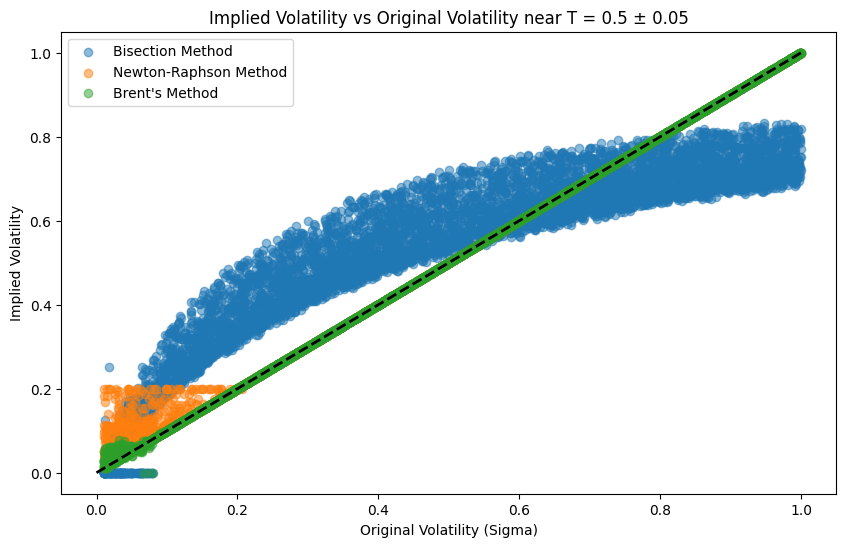

In [ ]:
# Plot implied volatilities against the original sigma
fixed_T = 0.5
tolerance = 0.05

# Filtering the DataFrame within this tolerance
specific_T_df = implied_volatilities_df[
    (implied_volatilities_df['T'] >= fixed_T - tolerance) &
    (implied_volatilities_df['T'] <= fixed_T + tolerance)
]

if len(specific_T_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.scatter(specific_T_df['Sigma'], specific_T_df['Bisection Imp Vol'], alpha=0.5, label='Bisection Method', color='#1f77b4')
    plt.scatter(specific_T_df['Sigma'], specific_T_df['Newton-Raphson Imp Vol'], alpha=0.5, label='Newton-Raphson Method', color='#ff7f0e')
    plt.scatter(specific_T_df['Sigma'], specific_T_df['Brent Imp Vol'], alpha=0.5, label="Brent's Method", color='#2ca02c')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('Original Volatility (Sigma)')
    plt.ylabel('Implied Volatility')
    plt.title(f'Implied Volatility vs Original Volatility near T = {fixed_T} ± {tolerance}')
    plt.legend()
    plt.show()
else:
    print("No data points match the selected criteria.")

In [ ]:
# Detecting where the Newton Raphson doesnt converge
nan_rows = option_prices_newton[option_prices_newton["Implied Volatility"].isna()]
nan_rows.describe()

# usually when sigma is bigger, the vega gets a null value, the smallest sigma for which we got a NaN is 0.238544. So from that to 0.999965
# Also we notice in the graph that the closest approximations are those with the brent method, thats why we will train our NN model on that dataset

,S/K,r,T,sigma,Option Prices,Implied Volatility,Difference
count,13709.000000,13709.000000,13709.000000,13709.000000,1.370900e+04,0.0,0.0
mean,0.933835,0.060519,0.588556,0.701231,2.698484e-01,NaN,NaN
std,0.467893,0.023175,0.257270,0.190518,2.854304e-01,NaN,NaN
min,0.400057,0.020001,0.200055,0.238544,1.163009e-10,NaN,NaN
25%,0.512377,0.040377,0.360936,0.553037,1.623522e-02,NaN,NaN
50%,0.652382,0.060707,0.560362,0.719611,7.632257e-02,NaN,NaN
75%,1.457147,0.080750,0.800104,0.864369,5.728728e-01,NaN,NaN
max,1.599962,0.099993,1.099943,0.999965,8.780571e-01,NaN,NaN


In [ ]:
# ANN Model for Imp Vol with BS model
# Adding the V/K column to option_prices
option_prices["V/K"] = option_prices["Option Prices"] * option_prices["S/K"]

option_prices_features = option_prices[["S/K", "r", "T", "sigma"]]
option_prices_target = option_prices["V/K"]

option_prices.head()

,S/K,r,T,sigma,Option Prices,V/K
0,0.908537,0.054381,0.323828,0.846186,0.145224,0.131941
1,0.821742,0.030448,0.728939,0.116410,0.001432,0.001177
2,1.440178,0.025436,0.656050,0.836684,0.596865,0.859592
3,1.279796,0.070649,0.960395,0.907837,0.574850,0.735690
4,0.676531,0.074265,0.820220,0.840793,0.128554,0.086971


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(option_prices_features, option_prices_target, test_size=0.1, random_state=42)

# Parameter grid for random search
param_dist = {
    'hidden_layer_sizes': [(400, 400, 400, 400)],
    'activation': ['relu', 'tanh', 'sigmoid', 'elu'],
    'solver': ['sgd', 'adam', 'rmsprop'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [256, 512, 1024, 2048, 3000],
    'early_stopping': [True, False]
}

mlp = MLPRegressor(max_iter=200)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

In [ ]:
# Evaluating the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:


mlp_model = MLPRegressor(hidden_layer_sizes= (400,400,400,400) , activation= "relu", solver= "adam", batch_size= 1024).fit(X_train, y_train)

In [ ]:
mlp_model.predict(X_test)

array([0.32243278, 0.36902706, 0.05978722, ..., 0.30868682, 0.69669338,
       0.51966612])

In [ ]:
mlp_model.score(X_test, y_test)

0.9449391169195949

In [ ]:
option_prices["mlp_sigma"] = mlp_model.predict(option_prices[["S/K", "r", "T", "V/K"]])

In [ ]:
option_prices

,S/K,r,T,sigma,Option Prices,V/K,mlp_sigma
0,0.908537,0.054381,0.323828,0.846186,0.145224,0.131941,0.860457
1,0.821742,0.030448,0.728939,0.116410,0.001432,0.001177,0.112997
2,1.440178,0.025436,0.656050,0.836684,0.596865,0.859592,0.854357
3,1.279796,0.070649,0.960395,0.907837,0.574850,0.735690,0.916765
4,0.676531,0.074265,0.820220,0.840793,0.128554,0.086971,0.859095
...,...,...,...,...,...,...,...
49995,0.837194,0.052365,1.024495,0.428654,0.104106,0.087157,0.437886
49996,0.916157,0.099241,0.731360,0.026556,0.003204,0.002935,0.045633
49997,0.689511,0.075301,0.920218,0.229057,0.006774,0.004671,0.232163
49998,1.415322,0.036217,0.270042,0.134744,0.425054,0.601588,0.301344


In [ ]:
mlp_sigma_test = mlp_model.predict(option_prices_features_test)

In [ ]:
mae(y_true= option_prices_target_test, y_pred= mlp_sigma_test)

0.029383685342790105

In [ ]:
mse(y_true= option_prices_target_test, y_pred= mlp_sigma_test)

0.003076581819110936

In [ ]:
mape(y_true= option_prices_target_test, y_pred= mlp_sigma_test)

0.3194144023856781

In [ ]:
x1 = pd.DataFrame(
  columns=["S/K", "r", "T", "Option Prices"]
)
x1["S/K"] = [1.3 for i in range(1000)]
x1["r"] = [ 0.4 for i in range(1000)]
x1["T"] = [ 1.2 for i in range(1000)]
x1["Option Prices"] = np.linspace(0,1.3,1000)
y1 = mlp_model.predict(x1)

In [ ]:
x2 = pd.DataFrame(
  columns=["S/K", "r", "T", "Option Prices"]
)
x2["S/K"] = [1 for i in range(1000)]
x2["r"] = [ 0.4 for i in range(1000)]
x2["T"] = [ 1.2 for i in range(1000)]
x2["Option Prices"] = np.linspace(0,1.3,1000)
y2 = mlp_model.predict(x2)

In [ ]:
x3 = pd.DataFrame(
  columns=["S/K", "r", "T", "Option Prices"]
)
x3["S/K"] = [0.7 for i in range(1000)]
x3["r"] = [ 0.4 for i in range(1000)]
x3["T"] = [ 1.2 for i in range(1000)]
x3["Option Prices"] = np.linspace(0,1.3,1000)
y3 = mlp_model.predict(x3)

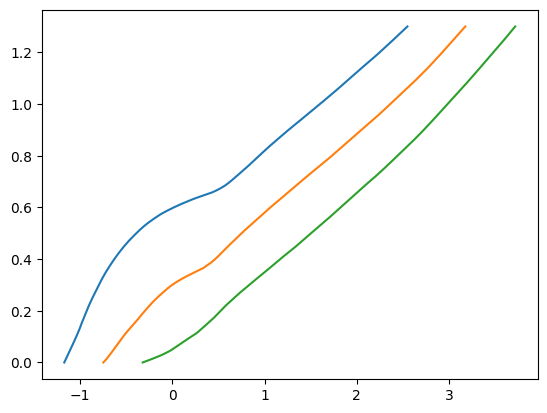

In [ ]:
plt.plot(y1,x1["Option Prices"])
plt.plot(y2,x2["Option Prices"])
plt.plot(y3,x3["Option Prices"])

<ipython-input-12-32e6079b9b4a>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(m)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))


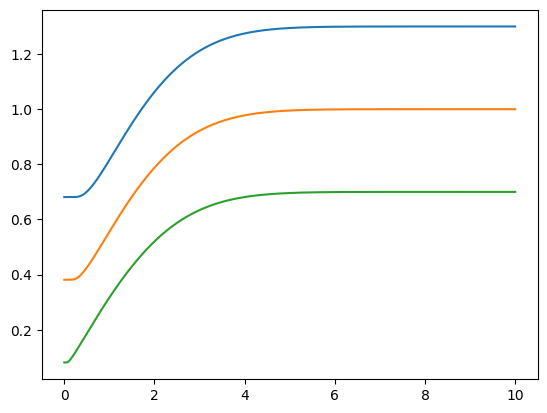

In [ ]:
x = np.linspace(0, 10, 1000)
y1 = [black_scholes_price(1.3, 0.4, 1.2, sigma) for sigma in x]
y2 = [black_scholes_price(1., 0.4, 1.2, sigma) for sigma in x]
y3 = [black_scholes_price(0.7, 0.4, 1.2, sigma) for sigma in x]
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)

In [ ]:
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=4)
sample = sampler.random(n=30000)

l_bounds = [0.4, 0.02, 0.2, 0.01]
u_bounds = [1.6, 0.1, 1.1, 1]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

data= pd.DataFrame(
  sample_scaled,
  columns=["S/K", "r", "T", "sigma"]
)
data["S/K"] = [1.3 for i in range(30000)]
data["T"] = [ 1.2 for i in range(30000)]
y3 = data.apply(
    lambda df: black_scholes_price(
        df["S/K"],
        df["r"],
        df["T"],
        df["sigma"]
    ),
    axis=1
)
data

,S/K,r,T,sigma
0,1.3,0.098298,1.2,0.903992
1,1.3,0.078621,1.2,0.032133
2,1.3,0.043553,1.2,0.312820
3,1.3,0.068826,1.2,0.123396
4,1.3,0.038596,1.2,0.093169
...,...,...,...,...
29995,1.3,0.081167,1.2,0.334194
29996,1.3,0.071120,1.2,0.640784
29997,1.3,0.068378,1.2,0.918022
29998,1.3,0.054581,1.2,0.338509


In [ ]:
x_features = data.copy()
y_target = y3

In [ ]:
x_features_train, x_features_test, y_target_train, y_target_test = train_test_split(x_features, y_target, random_state=1)

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes= (400,400,400,400) , activation= "relu", solver= "adam", batch_size= 1024).fit(x_features_train, y_target_train)

In [ ]:
mlp_model.predict(x_features_test)

array([0.40845737, 0.35414328, 0.38377736, ..., 0.52897674, 0.45643427,
       0.61099979])

In [ ]:
mlp_model.score(x_features_test, y_target_test)

0.9997916431942537

In [ ]:
x = np.linspace(0, 1, 1000)
y1 = [black_scholes_price(1.3, 0.4, 1.2, sigma) for sigma in x]
x3 = pd.DataFrame(
  columns=["S/K", "r", "T", "sigma"]
)
x3["S/K"] = [1.3 for i in range(1000)]
x3["r"] = [ 0.4 for i in range(1000)]
x3["T"] = [ 1.2 for i in range(1000)]
x3["sigma"] = np.linspace(0, 1, 1000)
y3 = mlp_model.predict(x3)

<ipython-input-12-32e6079b9b4a>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(m)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))


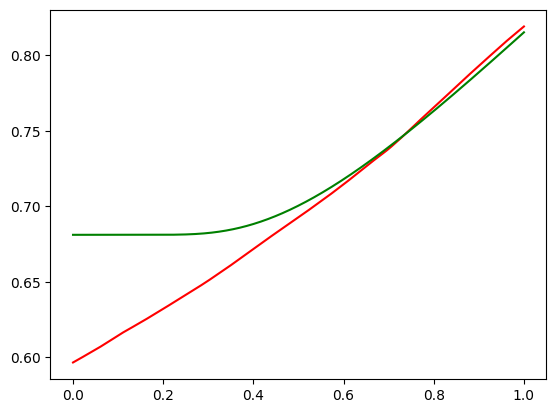

In [ ]:
plt.plot(x,y3, color = 'red')
plt.plot(x,y1,color='green')

In [ ]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm


def coth(x):
    return  np.cosh(x) / np.sinh(x)


def heston_characteristic_function(S, K, T, r, kappa, theta, sigma, rho, V, alpha):
    # Define some characteristic functions for the Heston model
    b = lambda nu: kappa - 1j * rho * sigma * nu
    gamma = lambda nu: np.sqrt(sigma**2 * (nu**2 + 1j * nu) + b(nu)**2)
    a = lambda nu: (b(nu) / gamma(nu)) * np.sinh(T * 0.5 * gamma(nu))
    c = lambda nu: gamma(nu) * coth(0.5 * T * gamma(nu)) + b(nu)
    d = lambda nu: kappa * theta * T * b(nu) / sigma**2

    f = lambda nu: 1j * (np.log(S) + r * T) * nu + d(nu)
    g = lambda nu: (np.cosh(T * 0.5 * gamma(nu)) + a(nu)) ** (2 * kappa * theta / sigma**2)
    h = lambda nu: -(nu**2 + 1j * nu) * V / c(nu)

    phi = lambda nu: np.exp(f(nu)) * np.exp(h(nu)) / g(nu)
    return phi


def call_price(S, K, T, r, kappa, theta, sigma, rho, V, alpha, L):
    # Get the characteristic functions
    phi = heston_characteristic_function(S, K, T, r, kappa, theta, sigma, rho, V, alpha)

    # Integrands
    integrand = lambda nu: np.real(
        phi(nu - 1j * (alpha + 1))
        / (alpha**2 + alpha - nu**2 + 1j * (2 * alpha + 1) * nu)
        * np.exp(-1j * np.log(K) * nu)
    )

    # Pricing formulas
    P = (np.exp(-r * T - alpha * np.log(K)) / np.pi) * quad(integrand, 0, L)[0]

    return P

In [ ]:
# alpha = 1.5, .. L petit pour T grand en general  L = 1000 pout T entre 0.5 et 1.4 et L = 100 pour T plus grand
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=8)
sample = sampler.random(n=1000000)

l_bounds = [0.6, 0.1, 0.0, 0.0, 0.0, 0.0, -0.95, 0.05]
u_bounds = [1.4, 1.4, 0.1, 2.0, 0.5, 0.5, 0.0, 0.5]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

option_prices_heston = pd.DataFrame(
  sample_scaled,
  columns=["S/K", "T", "r", "kappa", "theta", "sigma", "rho", "V"]
)

def compute_option_price(row):
    alpha = 1.5
    T = row["T"]
    if 0.5 <= T <= 1.4:
        L = 1000
    else:
        L = 100

    try:
        price = call_price(
            row["S/K"],
            1,  # Assuming K = 1 for normalized strike price
            row["T"],
            row["r"],
            row["kappa"],
            row["theta"],
            row["sigma"],
            row["rho"],
            row["V"],
            alpha,
            L
        )
        return price
    except (OverflowError, FloatingPointError, ValueError):
        return np.nan  # Return NaN for cases where numerical issues occur

option_prices_heston["Option Prices"] = option_prices_heston.apply(compute_option_price, axis=1)

option_prices_heston

<ipython-input-27-4ad69e5e7c16>:19: RuntimeWarning: overflow encountered in scalar power
  g = lambda nu: (np.cosh(T * 0.5 * gamma(nu)) + a(nu)) ** (2 * kappa * theta / sigma**2)
<ipython-input-27-4ad69e5e7c16>:22: RuntimeWarning: invalid value encountered in scalar divide
  phi = lambda nu: np.exp(f(nu)) * np.exp(h(nu)) / g(nu)
<ipython-input-27-4ad69e5e7c16>:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P = (np.exp(-r * T - alpha * np.log(K)) / np.pi) * quad(integrand, 0, L)[0]
<ipython-input-27-4ad69e5e7c16>:22: RuntimeWarning: overflow encountered in exp
  phi = lambda nu: np.exp(f(nu)) * np.exp(h(nu)) / g(nu)
<ipython-input-27-4ad69e5e7c16>:22: RuntimeWarning: invalid value encountered in scalar multiply
  phi = lambda nu: np.exp(f(nu)) * np.exp(h(nu)) / g(nu)
<ipython-input-27-4ad69e5e7c16>:38: IntegrationWarning: The maximum number of subdivisions (50) ha

In [ ]:
option_prices_heston.describe()

,S/K,T,r,kappa,theta,sigma,rho,V,Option Prices
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,6.780000e+02
mean,0.999995,0.749991,0.050001,1.000025,0.249989,0.249999,-0.475003,0.275000,1.863502e-01
std,0.231065,0.375469,0.028881,0.577630,0.144408,0.144403,0.274365,0.129966,1.425907e-01
min,0.600535,0.100492,0.000051,0.001729,0.000110,0.000345,-0.949951,0.050289,2.747360e-07
25%,0.800129,0.425240,0.025047,0.500706,0.125011,0.125195,-0.712114,0.162543,5.986555e-02
50%,0.999831,0.750106,0.049963,0.999934,0.250038,0.250076,-0.475224,0.275014,1.633252e-01
75%,1.199762,1.074629,0.074955,1.499563,0.374851,0.374935,-0.237973,0.387251,3.004134e-01
max,1.399306,1.399090,0.099977,1.998378,0.499947,0.499915,-0.000416,0.499841,5.643559e-01


In [ ]:
option_prices_heston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   S/K            1000 non-null   float64
 1   T              1000 non-null   float64
 2   r              1000 non-null   float64
 3   kappa          1000 non-null   float64
 4   theta          1000 non-null   float64
 5   sigma          1000 non-null   float64
 6   rho            1000 non-null   float64
 7   V              1000 non-null   float64
 8   Option Prices  678 non-null    float64
dtypes: float64(9)
memory usage: 70.4 KB


In [ ]:
def implied_volatility(m, r, T, market_price, tol=1e-6, max_iter=100):
    def error_function(sigma):
        return black_scholes_price(m, r, T, sigma) - market_price

    vol_lower_bound = 1e-6
    vol_upper_bound = 5.0

    try:
        implied_vol = brentq(error_function, vol_lower_bound, vol_upper_bound, xtol=tol)
        return implied_vol
    except ValueError as e:
        return np.nan # Return NaN value if Brent fails to converge

In [ ]:
def calculate_implied_volatility(row):
    S_K = row['S/K']
    T = row['T']
    r = row['r']
    market_price = row['Option Prices']

    try:
        implied_vol = implied_volatility(S_K, r, T, market_price)
        return implied_vol
    except RuntimeError as e:
        return np.nan

option_prices_heston['Implied Volatility'] = option_prices_heston.apply(calculate_implied_volatility, axis=1)

option_prices_heston

,S/K,T,r,kappa,theta,sigma,rho,V,Option Prices,Implied Volatility
0,1.263836,1.208004,0.063931,0.860651,0.415795,0.387905,-0.205877,0.407926,NaN,NaN
1,1.385322,0.493500,0.088222,0.663912,0.142636,0.497006,-0.933343,0.197488,0.457196,0.494887
2,1.239682,0.389927,0.027009,1.055016,0.130399,0.398743,-0.578049,0.336617,0.310397,0.560112
3,0.762653,1.279869,0.068242,1.794978,0.008970,0.340953,-0.535796,0.281727,0.056293,0.312606
4,0.837562,1.048034,0.031442,1.180850,0.484383,0.425519,-0.296724,0.239258,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
995,1.096195,0.832158,0.024731,0.429548,0.154423,0.438493,-0.349901,0.063264,0.172099,0.275141
996,1.309391,0.694932,0.099446,1.898751,0.125062,0.364588,-0.030232,0.486321,0.448368,0.569738
997,1.344093,0.496735,0.063735,1.982383,0.241628,0.255012,-0.890878,0.212034,0.411829,0.493403
998,1.001513,0.905845,0.001542,0.560291,0.113832,0.453459,-0.226277,0.124451,0.126698,0.331185


In [ ]:
option_prices_heston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   S/K                 1000 non-null   float64
 1   T                   1000 non-null   float64
 2   r                   1000 non-null   float64
 3   kappa               1000 non-null   float64
 4   theta               1000 non-null   float64
 5   sigma               1000 non-null   float64
 6   rho                 1000 non-null   float64
 7   V                   1000 non-null   float64
 8   Option Prices       678 non-null    float64
 9   Implied Volatility  678 non-null    float64
dtypes: float64(10)
memory usage: 78.2 KB


In [ ]:
option_prices_heston.dropna(inplace= True)

In [ ]:
option_prices_heston_features_op = option_prices_heston[["S/K", "r", "T", "kappa", "theta", "sigma", "rho", "V"]]
option_prices_heston_target_op = option_prices_heston["Option Prices"]

In [ ]:
option_prices_heston_features_op_train, option_prices_heston_features_op_test, option_prices_heston_target_op_train, option_prices_heston_target_op_test = train_test_split(option_prices_heston_features_op, option_prices_heston_target_op, random_state=1)

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes= (400,400,400,400) , activation= "relu", solver= "adam", batch_size= 1024).fit(option_prices_heston_features_op_train, option_prices_heston_target_op_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


In [ ]:
mlp_heston_op_prediction = mlp_model.predict(option_prices_heston_features_op_test)

In [ ]:
mlp_model.score(option_prices_heston_features_op_test, option_prices_heston_target_op_test)

0.9754692226161304

In [ ]:
mae(y_true= option_prices_heston_target_op_test, y_pred= mlp_heston_op_prediction)

0.0162838816932691

In [ ]:
mse(y_true= option_prices_heston_target_op_test, y_pred= mlp_heston_op_prediction)

0.00048156534446808355

In [ ]:
mape(y_true= option_prices_heston_target_op_test, y_pred= mlp_heston_op_prediction)

23.766259727061485

In [ ]:
option_prices_heston["mlp_option_price"] = mlp_model.predict(option_prices_heston[["S/K", "r", "T", "kappa", "theta", "sigma", "rho", "V"]])

In [ ]:
option_prices_heston

,S/K,T,r,kappa,theta,sigma,rho,V,Option Prices,Implied Volatility,mlp_option_price
1,1.385322,0.493500,0.088222,0.663912,0.142636,0.497006,-0.933343,0.197488,0.457196,0.494887,0.376218
2,1.239682,0.389927,0.027009,1.055016,0.130399,0.398743,-0.578049,0.336617,0.310397,0.560112,0.317139
3,0.762653,1.279869,0.068242,1.794978,0.008970,0.340953,-0.535796,0.281727,0.056293,0.312606,0.070931
5,1.098828,0.855584,0.054551,1.231914,0.081585,0.314546,-0.753638,0.456266,0.288414,0.556795,0.290692
6,1.320254,0.794081,0.037844,0.293687,0.327674,0.234401,-0.600807,0.362944,0.456027,0.606111,0.456845
...,...,...,...,...,...,...,...,...,...,...,...
995,1.096195,0.832158,0.024731,0.429548,0.154423,0.438493,-0.349901,0.063264,0.172099,0.275141,0.186333
996,1.309391,0.694932,0.099446,1.898751,0.125062,0.364588,-0.030232,0.486321,0.448368,0.569738,0.413013
997,1.344093,0.496735,0.063735,1.982383,0.241628,0.255012,-0.890878,0.212034,0.411829,0.493403,0.348183
998,1.001513,0.905845,0.001542,0.560291,0.113832,0.453459,-0.226277,0.124451,0.126698,0.331185,0.142525


In [ ]:
option_prices_heston_features_iv = option_prices_heston[["S/K", "r", "T", "kappa", "theta", "sigma", "rho", "V", "Option Prices"]]
option_prices_heston_target_iv = option_prices_heston["Implied Volatility"]

In [ ]:
option_prices_heston_features_iv_train, option_prices_heston_features_iv_test, option_prices_heston_target_iv_train, option_prices_heston_target_iv_test = train_test_split(option_prices_heston_features_iv, option_prices_heston_target_iv, random_state=1)

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes= (400,400,400,400) , activation= "relu", solver= "adam", batch_size= 1024).fit(option_prices_heston_features_iv_train, option_prices_heston_target_iv_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


In [ ]:
mlp_heston_iv_prediction = mlp_model.predict(option_prices_heston_features_iv_test)

In [ ]:
mlp_model.score(option_prices_heston_features_iv_test, option_prices_heston_target_iv_test)

0.9442205715095291

In [ ]:
mae(y_true= option_prices_heston_target_iv_test, y_pred= mlp_heston_iv_prediction)

0.019625396338301182

In [ ]:
mse(y_true= option_prices_heston_target_iv_test, y_pred= mlp_heston_iv_prediction)

0.0006525128589335712

In [ ]:
mape(y_true= option_prices_heston_target_iv_test, y_pred= mlp_heston_iv_prediction)

0.04436705891250656

In [ ]:
option_prices_heston["mlp_iv"] = mlp_model.predict(option_prices_heston[["S/K", "r", "T", "kappa", "theta", "sigma", "rho", "V", "Option Prices"]])

In [ ]:
option_prices_heston

,S/K,T,r,kappa,theta,sigma,rho,V,Option Prices,Implied Volatility,mlp_option_price,mlp_iv
1,1.385322,0.493500,0.088222,0.663912,0.142636,0.497006,-0.933343,0.197488,0.457196,0.494887,0.376218,0.448199
2,1.239682,0.389927,0.027009,1.055016,0.130399,0.398743,-0.578049,0.336617,0.310397,0.560112,0.317139,0.556670
3,0.762653,1.279869,0.068242,1.794978,0.008970,0.340953,-0.535796,0.281727,0.056293,0.312606,0.070931,0.332124
5,1.098828,0.855584,0.054551,1.231914,0.081585,0.314546,-0.753638,0.456266,0.288414,0.556795,0.290692,0.620214
6,1.320254,0.794081,0.037844,0.293687,0.327674,0.234401,-0.600807,0.362944,0.456027,0.606111,0.456845,0.642322
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.096195,0.832158,0.024731,0.429548,0.154423,0.438493,-0.349901,0.063264,0.172099,0.275141,0.186333,0.289245
996,1.309391,0.694932,0.099446,1.898751,0.125062,0.364588,-0.030232,0.486321,0.448368,0.569738,0.413013,0.630822
997,1.344093,0.496735,0.063735,1.982383,0.241628,0.255012,-0.890878,0.212034,0.411829,0.493403,0.348183,0.477484
998,1.001513,0.905845,0.001542,0.560291,0.113832,0.453459,-0.226277,0.124451,0.126698,0.331185,0.142525,0.331173
